In [6]:
import numpy as np
import math
from scipy.interpolate import interp1d
import tensorflow as tf
from keras import Sequential, Input
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.optimizers.schedules import ExponentialDecay
import toml
import os
import shutil
from datetime import datetime
import matplotlib.pyplot as plt

In [4]:
def genere_X(n,trou,corrupt):
  #  Si trou <= 0 : Genere un echantillon uniforme sur [-1,1]
  #  Si (0< trou <1) : Genere un échantillon dont le support est dans [-1,-trou] U [trou, 1]
  #  Si (0< trou <1) et (corrupt != 0) : ajoute un example 0.
    X = np.zeros(n)

    if (trou > 0) & (trou < 1):
        n2 = math.floor(n/2)
        X[0:n2] =  np.random.uniform(-1, -trou, n2)
        X[n2:] = np.random.uniform(trou , 1, n2)
        if (corrupt != 0):
            X[np.random.randint(0, n)] = 0.5
    else :
        X = np.random.uniform(0, 1, n)

    return X.reshape(-1, 1)
################################################################
def genere_Y(X,corrupt_value, noise_variance):
    # Genere Y suivant la fonction valeur absolue
    # Si une entrée de X vaut 0.5, le Y correspondant vaut corrupt_value
    Y =  np.abs(X) + noise_variance * np.random.randn(X.shape[0], 1)

    indices = np.where(X == 0.5)[0]
    if indices.size > 0:
        Y[indices] = corrupt_value

    return Y
################################################################
def genere_NN_dense(X,taille_output,largeur,profondeur):
    # X : sert à donner la taille de la couche d'entrée
    # taille_output : donne la taille de la couche de sortie
    # largeur : c'est la largeur des couches cachées
    # profondeur : Le nombre de couches cachées

    model = Sequential()   #crée un réseau de neurone vide
    # Ajout de la première couche avec input_shape
    model.add(Dense(largeur, activation='relu', kernel_initializer='he_normal', input_shape=(X.shape[1],)))

    for i in range(profondeur-1):      # crée les couches cachées
        model.add(Dense(largeur, activation='relu', kernel_initializer='he_normal'))

    model.add(Dense(1, activation='linear', kernel_initializer='he_normal'))  #crée la couche de sortie

    y = model(X) # Pour donner la taille de la première couche

    return model
################################################################


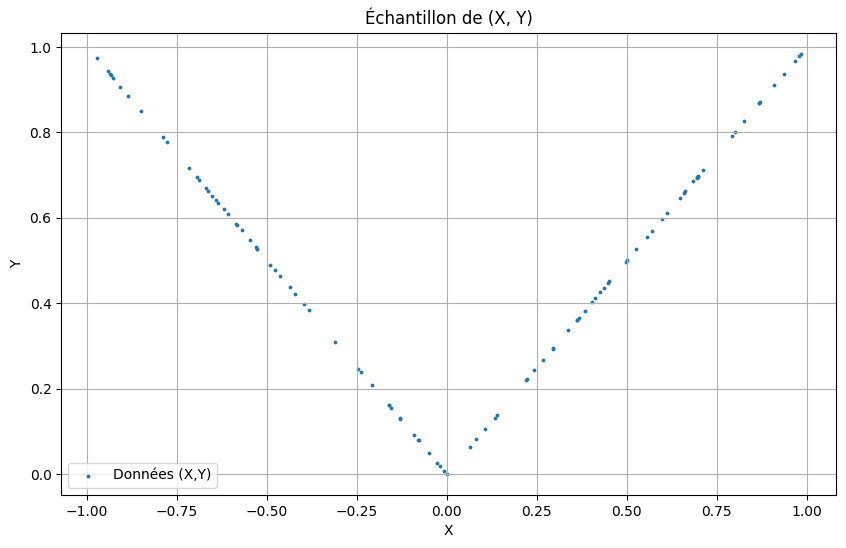

In [20]:
# caracteristiques de la distribution (X,Y)
trou = 0.0001     # 0 ou dans (0,1)
corrupt = 0    # Pour visualiser que le réseau peut prendre n'importe quelle valeur en 0.
corrupt_value = 10    # idem
noise_variance = 0.   # variance du bruit

# Définir la taille de l'échantillon
n = 100  # Nombre de points dans l'échantillon

# Génére X
X = genere_X(n,trou,corrupt )
Y = genere_Y(X,corrupt_value,noise_variance)

# Afficher (X,Y)
plt.figure(figsize=(10, 6))
plt.scatter(X, Y, label='Données (X,Y)', alpha=1, s=3)
plt.title("Échantillon de (X, Y)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid()
plt.show()

In [8]:
class ReLU_network:
    """
    A class to define, train, and evaluate a ReLU neural network.
    """
    def __init__(self, network_cfg, scheduler_cfg=None):
        """Initializes a neural network with a given architecture and learning rate."""
        layers = network_cfg['layers']
        learning_rate = network_cfg['learning_rate']

        self.nnet = Sequential()
        self.nnet.add(Input(shape=(layers[0],)))
        for size in layers[1:-1]:
            self.nnet.add(Dense(size, activation='relu', kernel_initializer='he_normal'))
        self.nnet.add(Dense(layers[-1], activation='linear', kernel_initializer='he_normal'))
        
        self.initial_learning_rate = learning_rate
        
        optimizer_name = network_cfg.get('optimizer', 'adam').lower()
        if optimizer_name == 'adam':
            optimizer = Adam(learning_rate=learning_rate)
        elif optimizer_name == 'sgd':
            momentum = network_cfg.get('momentum', 0.0) # Default to 0 if not specified
            optimizer = SGD(learning_rate=learning_rate, momentum=momentum, nesterov=(momentum > 0))
        else:
            raise ValueError(f"Unsupported optimizer: '{optimizer_name}'. Please use 'adam' or 'sgd'.")
        self.nnet.compile(optimizer=optimizer, loss='mse')

    def train(self, X_train, Y_train, X_val, Y_val, epochs, batch_size=32, callbacks=None, verbose=1):
        """Trains the neural network."""
        return self.nnet.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, 
                           validation_data=(X_val, Y_val), verbose=1, callbacks=callbacks)

    def evaluate(self, X):
        """Predicts outputs for given inputs."""
        return self.nnet.predict(X, verbose=0)

In [13]:
config_path = 'config.toml'
if not os.path.exists(config_path):
    print(f"Error: Configuration file '{config_path}' not found.")
    
try:
    with open(config_path, 'r', encoding='utf-8') as f:
        config = toml.load(f)
except Exception as e:
    print(f"\nAn error occurred: {e}")

In [21]:

# --- 1. Load Parameters from Config ---
target_func_cfg = config['target_function']
dataset_cfg = config['dataset']
network_cfg = config['network']
scheduler_cfg = config.get('learning_rate_scheduler') # Can be None
output_cfg = config['output']
print("✓ Configuration loaded.")

# --- 2. Create Target Function ---
breakpoints_x = np.array(target_func_cfg['x_coords'])
breakpoints_y = np.array(target_func_cfg['y_coords'])

if len(breakpoints_x) < 2:
    raise ValueError("Target function requires at least 2 breakpoints.")

sort_indices = np.argsort(breakpoints_x)
interpolated_function = interp1d(
    breakpoints_x[sort_indices], 
    breakpoints_y[sort_indices], 
    kind='linear', 
    fill_value="extrapolate"
)
print("✓ Target function created.")

# --- 3. Generate Dataset ---
x_data = np.random.uniform(target_func_cfg['x_min'], target_func_cfg['x_max'], size=dataset_cfg['num_samples'])
y_data = interpolated_function(x_data) + np.random.normal(0, dataset_cfg['noise_std_dev'], size=dataset_cfg['num_samples'])

x_train = x_data.reshape(-1, 1)
y_train = y_data.reshape(-1, 1)

x_val = np.linspace(target_func_cfg['x_min'], target_func_cfg['x_max'], 100).reshape(-1, 1)
y_val = interpolated_function(x_val).reshape(-1, 1)

print(f"✓ Dataset generated with {dataset_cfg['num_samples']} samples.")

# --- 4. Initialize and Train the Neural Network ---
loss_threshold = output_cfg.get('loss_threshold', 0.0)
run_count = 0


run_count += 1
print(f"\n▶ Training Run #{run_count} (target loss >= {loss_threshold})...")

# Initialize a new network and the custom callback for each attempt
nnet = ReLU_network(network_cfg, scheduler_cfg=scheduler_cfg)

history = nnet.train(X, Y, x_val, y_val, 
                        epochs=network_cfg['epochs'], 
                        batch_size=network_cfg.get('batch_size', 32))


# If we reach here, training completed all epochs without the loss dropping below the threshold.
# This is the scenario we want to capture.
final_loss = history.history['val_loss'][-1]
print(f"  Final Validation Loss: {final_loss:.6f}")


# --- 5. Generate Predictions for Plotting ---
x_pred_space = np.linspace(target_func_cfg['x_min'], target_func_cfg['x_max'], 1000).reshape(-1, 1)
y_pred = nnet.evaluate(x_pred_space)

# --- 6. Plotting Results ---
plt.figure(figsize=(10, 7))

# Plot target function
plt.plot(x_pred_space, interpolated_function(x_pred_space), 'b-', label='Target Function', linewidth=2)
plt.scatter(breakpoints_x[sort_indices], breakpoints_y[sort_indices], color='blue', zorder=5, label='Breakpoints')

# Plot network prediction
plt.plot(x_pred_space, y_pred, 'g-', label='NN Prediction', linewidth=2)

# Plot training samples
plt.scatter(x_train, y_train, color='orange', alpha=0.5, s=20, label='Training Samples')

plt.title('Target Function vs. Trained Network Prediction', fontsize=16)
plt.xlabel('Input (x)', fontsize=12)
plt.ylabel('Output (y)', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.ylim(bottom=0) # Adjust as needed

# --- 7. Save and Finalize ---
if output_cfg.get('save_experiment', False):
    now = datetime.now()
    date_time_str = now.strftime("%Y-%m-%d_%H-%M-%S")
    output_path = os.path.join(output_cfg['results_base_dir'], f"single_run_{date_time_str}")
    
    os.makedirs(output_path, exist_ok=True)
    
    shutil.copy('config.toml', os.path.join(output_path, 'config.toml'))
    
    plot_filename = os.path.join(output_path, 'prediction_vs_target.png')
    plt.savefig(plot_filename)
    print(f"\n✓ Plot saved to '{plot_filename}'.")
    
    # Save model weights and biases
    weights_filename = os.path.join(output_path, 'model.weights.h5')
    nnet.nnet.save_weights(weights_filename)
    print(f"✓ Model weights saved to '{weights_filename}'.")

plt.close()

✓ Configuration loaded.
✓ Target function created.
✓ Dataset generated with 100 samples.

▶ Training Run #1 (target loss >= 0)...
Epoch 1/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.1595 - val_loss: 0.4795
Epoch 2/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1078e-04 - val_loss: 0.7327
Epoch 3/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 9.6534e-05 - val_loss: 0.0227
Epoch 4/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0712e-05 - val_loss: 0.0295
Epoch 5/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.7347e-05 - val_loss: 0.0044
Epoch 6/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 6.5914e-06 - val_loss: 0.0057
Epoch 7/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3304e-06 - val_loss: 0.0050
Epoch 8/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.4149e-06 - val_loss: 8.4850e-04
Epoch 9/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.0264e-07 - val_loss: 2.7885e-04
Epoch 10/1000
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - 

KeyboardInterrupt: 